In [1]:
# Notebook behavior:
from pathlib import Path
import sys

# Enable multiple outputs from one cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Markdown, Image

def add_to_sys_path(this_path, up=False):
    """
    To be used if the current project is not (yet)  packaged.
    Prepend this_path to sys.path.
    If up=True, path refers to parent folder (1 level up).
    """
    if up:
        newp = Path(this_path).parent
    else:
        newp = Path(this_path)
    src = newp.joinpath("src")
    if src.exists():
        newp = str(src)
    else:
        newp = str(newp)
    if newp not in sys.path:
        sys.path.insert(1, newp)
        print('Path added to sys.path: {}'.format(newp))
        

# autoreload extension: automaticall refresh imports when code is changed:
%load_ext autoreload
%autoreload 2

In [2]:
import shutil

mc4_path = shutil.which("mcce")
if mc4_path is not None and "MCCE4" in mc4_path:
    MC4 = Path(mc4_path)
    bin_dir = MC4.parent
    mcbin_dir = bin_dir.parent.joinpath("MCCE_bin")

    # Add them to the system path to enable imports
    add_to_sys_path(mcbin_dir)
    add_to_sys_path(bin_dir)
else:
    print("Missing MCCE4 where the codebase for ms_protonation resides: export a MCCE4 clone path to your PATH.")

Path added to sys.path: /home/cat/projects/MCCE4/MCCE_bin
Path added to sys.path: /home/cat/projects/MCCE4/bin


---
# run_cms_analysis2.ipynb - Uses 'fast loading' class MSout_np
---

# Tutorial notebook for processing MCCE microstate file in ms_out folder.

# Required mcce run output files:
### 1. head3.lst
### 2. file in ms_out/, a.k.a. the 'msout file'
 * Notes:
   - The ms_out folder is retained when the `--ms` flag is used at the command line for Step 4: `step4.py --ms`;
   - Format of the msout file name: pHXeHYms.tx at pH point X and Eh point Y;
   - The most typical filename encountered is "pH7eH0ms.txt", meaning the MCCE simulation was a pH titation run at pH7.
---

## Load the needed libraries and modules:

In [3]:
import numpy as np
# Module needed to read the microstate file:
import mcce4.cms_analysis_wc.analysis as msa
import mcce4.cms_analysis_wc.parameters as prm

---
# Inputs
## Required user input: the path to the msout file:
 * e.g. 4lzt/ms_out/pH7eH0ms.txt
## Optional user input: list of residues of interest
---

# Get the paths to the input files using a folder name and a pH point:

In [4]:
mcce_dir = Path("4lzt")  # local folder
msout_file = "pH7eH0ms.txt"
ph = 7
eh = 0

# Ensure the output directory exists:
outname = f"crgms_corr_ph{ph}eh{eh}"
output_dir = mcce_dir.joinpath(outname)
if not output_dir.exists():
    output_dir.mkdir()
    
h3_path = mcce_dir.joinpath("head3.lst")
msout_path = mcce_dir.joinpath("ms_out", msout_file)

print(f"head3_path: {str(h3_path)}")
print(f"msout_path: {str(msout_path)}")
print(f"output_dir: {str(output_dir)}")

head3_path: 4lzt/head3.lst
msout_path: 4lzt/ms_out/pH7eH0ms.txt
output_dir: 4lzt/crgms_corr_ph7eh0


# Residues of interest

Note: Make sure to add the names of your residues of interest, such as quinone, here:

### Which kind of residues to consider (3-letter codes)

#### Code for interactive input to obtain `user_resoi`:
Example string to give:  
ASP, pl9 GLU, LYS ARG HIS, TYR NTR PAA, HEM
   
  ```
  user_resoi = msa.split_spunct(input("Enter which kind of residues are of interest, e.g. ASP, HIS:\n"), upper=True)
  ```

In [5]:
# Which kind of residues to consider (3-letter codes):

user_resoi = prm.IONIZABLES  # :: ['ASP', 'GLU', 'ARG', 'HIS', 'LYS', 'CYS', 'TYR', 'NTR', 'CTR']
user_resoi = ['ASP', 'GLU']
user_resoi = ["ASP", "HEM", "PL9", "GLU", "HIS", "TYR", "NTR", "CTR"]

residue_kinds = prm.sort_resoi_list(user_resoi)
print("Sorted resoi kinds:", residue_kinds)

Sorted resoi kinds: ['ASP', 'GLU', 'HIS', 'TYR', 'NTR', 'CTR', 'HEM', 'PL9']


In [6]:
# Helper function to list resid from head3.lst; can be used to select 'choose_res':
# Uncomment to display:

#print(msa.list_head3_ionizables(h3_path))

In [7]:
# Specific residues of interest for correlation.
# Here, the list supplied must be conformer ids as they appear in the conformers list, without "-" or "+";
# Use helper function above if needed:
choose_res = [
'NTRA0001_',
'LYSA0001_',
'ARGA0005_',
'GLUA0007_',
'LYSA0013_',
'ARGA0014_',
'LYSA0033_',
'GLUA0035_',
'ARGA0045_',
'ASPA0048_',
'ASPA0052_',
'TYRA0053_',
]
print("Chosen resid for correlation (before validation):", choose_res)

Chosen resid for correlation (before validation): ['NTRA0001_', 'LYSA0001_', 'ARGA0005_', 'GLUA0007_', 'LYSA0013_', 'ARGA0014_', 'LYSA0033_', 'GLUA0035_', 'ARGA0045_', 'ASPA0048_', 'ASPA0052_', 'TYRA0053_']


# Instantiate msa.MSout_np

In [8]:
mc = msa.MSout_np(h3_path, msout_path, res_kinds=residue_kinds, mc_load="crg")

print(mc)


Head3 lookup array 'conf_info'
	fields :: iconf:0, resid:1, in_kinds:2, is_ioniz:3, is_fixed:4, is_free:5, resix:6, crg:7

Protonation microstates: 32,021

Elapsed time - Loading msout for cms: 1.49 s (0.02 min).


Conformers: 270
Conformational state space: 1,200,000
Free residues: 41
Fixed residues: 78



# Validate choose_res:

In [9]:
correl_resids = prm.check_res_list(choose_res, res_lst=residue_kinds, conf_info=mc.conf_info)
print("Valid resid for correlation:", correl_resids)

[WARNING]: mcce4.cms_analysis_wc.parameters:
	Ignoring 'LYSA0001_' from correl_lst: LYS not in residue_kinds.
[WARNING]: mcce4.cms_analysis_wc.parameters:
	Ignoring 'ARGA0005_' from correl_lst: ARG not in residue_kinds.
[WARNING]: mcce4.cms_analysis_wc.parameters:
	Ignoring 'LYSA0013_' from correl_lst: LYS not in residue_kinds.
[WARNING]: mcce4.cms_analysis_wc.parameters:
	Ignoring 'ARGA0014_' from correl_lst: ARG not in residue_kinds.
[WARNING]: mcce4.cms_analysis_wc.parameters:
	Ignoring 'LYSA0033_' from correl_lst: LYS not in residue_kinds.
[WARNING]: mcce4.cms_analysis_wc.parameters:
	Ignoring 'ARGA0045_' from correl_lst: ARG not in residue_kinds.
[WARNING]: mcce4.cms_analysis_wc.parameters:
	Removing 'TYRA0053_' from correl_lst: not in conformer space.


Valid resid for correlation: ['NTRA0001_', 'GLUA0007_', 'GLUA0035_', 'ASPA0048_', 'ASPA0052_']


# fixed res info:

In [10]:
all_fixed_res_crg_df = mc.get_fixed_residues_df()

# free res average crg

In [11]:
free_res_aver_crg_df = mc.get_free_res_aver_crg_df()

free_res_aver_crg_df

,Residue,crg
0,NTRA0001_,0.0
1,GLUA0007_,-1.0
2,HISA0015_,0.0
3,TYRA0020_,0.0
4,GLUA0035_,-1.0
5,ASPA0048_,-1.0
6,ASPA0052_,-1.0
7,ASPA0066_,-1.0
8,ASPA0101_,-1.0


# Combine free & fixed res with crg and save to csv:

## Output file: output_dir / "all_res_crg.csv"

In [12]:
all_res_crg_df = msa.combine_all_free_fixed_residues(free_res_aver_crg_df, all_fixed_res_crg_df)
all_res_crg_csv = output_dir.joinpath("all_res_crg.csv")

print("Saving all_res_crg_df to file.\n", "Note: For residues with 'free' status, the charge is the average charge.")
all_res_crg_df.to_csv(all_res_crg_csv)

Saving all_res_crg_df to file.
 Note: For residues with 'free' status, the charge is the average charge.


# Fixed residues of interest (resoi) info:

## Output file: output_dir / "fixed_crg_resoi.csv"

In [13]:
fixed_resoi_crg_df = mc.get_fixed_res_of_interest_df()
n_fixed_resoi = fixed_resoi_crg_df.shape[0]
if n_fixed_resoi:
    print(f"Fixed res in residues of interest: {n_fixed_resoi}")
    fixed_resoi_crg_df.to_csv(output_dir.joinpath("fixed_crg_resoi.csv"), index=False)
else:
    fixed_resoi_crg_df = None
    print("No fixed residues of interest.")

Fixed res in residues of interest: 6


# Energies distribution plot:

## Output file: output_dir / "enthalpy_dist.png"

Microstate energy distribution figure saved: 4lzt/crgms_corr_ph7eh0/enthalpy_dist.png


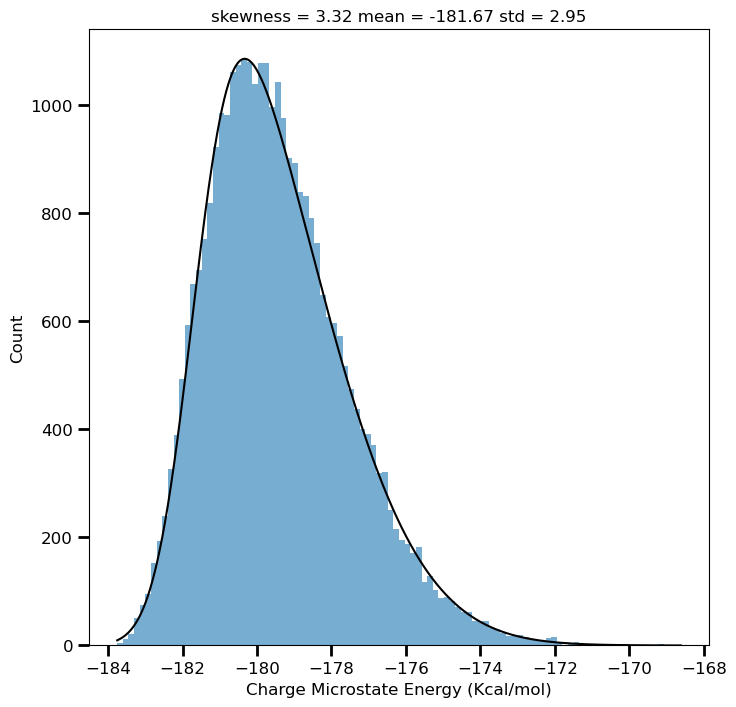

In [14]:
msa.energy_distribution(mc.all_cms, output_dir, kind="cms", save_name="enthalpy_dist.png", show=True)

# Get the top N cms data

 * Note: top_df corresponds to all_res_crg_df in the previous version of cms_analysis_wc.py.

### Define the number of top cms desired & the occ threshold:

In [15]:
n_top = 5              # default is 5
min_threshold = 0.0   # default is 0%

# get uniq cms:
mc.get_uniq_ms()
top_cms, _ = mc.get_topN_data(N=n_top, min_occ=min_threshold)

# second output (top_ms) is not populate bc the loading mode in "crg": charge ms only
# otherwise, top_ms would hold conformer space data that can be used to create a ms-pdb

Elapsed time - Populating .uniq_cms array: 0.03 s (0.00 min).

Unique protonation microstates: 14

Processing unique cms for requested top 5 at min_occ = 0.0%
Number of top cms returned: 5


## Create a df for the crg ms data:

## Output file: output_dir / "all_crg_count_res.csv"

In [22]:
# create a df for the crg ms data:
top_df = mc.top_cms_df(top_cms, cms_wc_format=True)
top_df.shape

crg_count_csv = output_dir.joinpath("all_crg_count_res.csv")
top_df.to_csv(crg_count_csv, header=True)

(5, 12)

In [23]:
if top_df.shape[0]:
    print("Sum Count: {:,.0f}\nSum Occ  : {:.0%}".format(*top_df[top_df.columns[-3:-1]].sum()))
    top_df
else:
    print("NO TOP DATA: top_df is empty")

Sum Count: 1,192,976
Sum Occ  : 99%


Residue,NTRA0001_,GLUA0007_,HISA0015_,TYRA0020_,GLUA0035_,ASPA0048_,ASPA0052_,ASPA0066_,ASPA0101_,Count,Occupancy,SumCharge
Order,,,,,,,,,,,,
1,0,-1,0,0,-1,-1,-1,-1,-1,638774,0.5323,4
2,0,-1,1,0,-1,-1,-1,-1,-1,367594,0.3063,5
3,1,-1,0,0,-1,-1,-1,-1,-1,119051,0.0992,5
4,1,-1,1,0,-1,-1,-1,-1,-1,58866,0.0491,6
5,0,-1,0,0,0,-1,-1,-1,-1,8691,0.0072,5


## Add fixed res of interest crg to top df  & save to csv

## Output file: output_dir / "all_crg_count_resoi.csv"

In [38]:
all_res_crg_df = msa.add_fixed_resoi_crg_to_topdf(top_df, fixed_resoi_crg_df, cms_wc_format=True)
all_res_crg_df.shape

crg_count_csv = output_dir.joinpath("all_crg_count_resoi.csv")
all_res_crg_df.to_csv(crg_count_csv)

all_res_crg_df

(5, 18)

Residue,NTRA0001_,GLUA0007_,HISA0015_,TYRA0020_,GLUA0035_,ASPA0048_,ASPA0052_,ASPA0066_,ASPA0101_,ASPA0018_,TYRA0023_,TYRA0053_,ASPA0087_,ASPA0119_,CTRA0129_,Count,Occupancy,SumCharge
Order,,,,,,,,,,,,,,,,,,
1,0,-1,0,0,-1,-1,-1,-1,-1,-5,0,0,-5,-5,-5,638774,0.5323,4
2,0,-1,1,0,-1,-1,-1,-1,-1,-5,0,0,-5,-5,-5,367594,0.3063,5
3,1,-1,0,0,-1,-1,-1,-1,-1,-5,0,0,-5,-5,-5,119051,0.0992,5
4,1,-1,1,0,-1,-1,-1,-1,-1,-5,0,0,-5,-5,-5,58866,0.0491,6
5,0,-1,0,0,0,-1,-1,-1,-1,-5,0,0,-5,-5,-5,8691,0.0072,5


# Protonation states energy histograms

### Without filtering: All Protonation Microstates Energy

Figure saved: 4lzt/crgms_corr_ph7eh0/crgms_logcount_vs_all_E.png


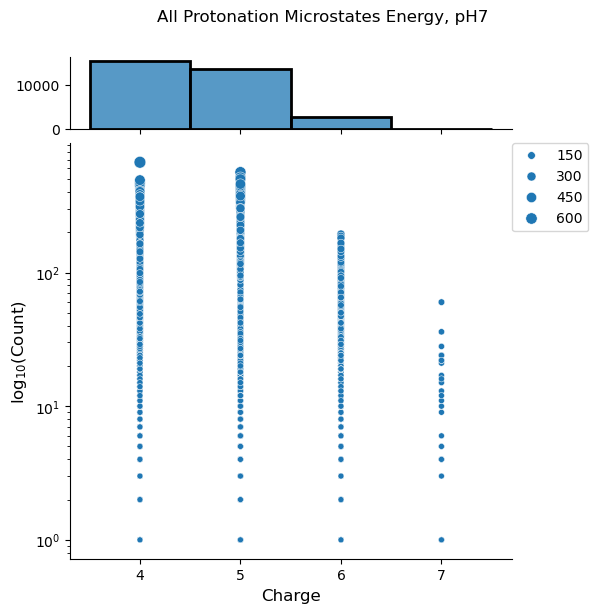

In [39]:
fig_title = f"All Protonation Microstates Energy, pH{ph}"

msa.crgms_energy_histogram(mc.all_cms,
                            mc.background_crg,
                            fig_title,
                            output_dir,
                            save_name="crgms_logcount_vs_all_E.png",
                            show=True)

### get min, aver & max E of crg ms

In [40]:
cms_E_stats = mc.get_cms_energy_stats()

### Protonation Microstates Energy within 1.36 kcal/mol of Lowest cms E

In [ ]:
E_bounds = (cms_E_stats[0], cms_E_stats[0] + 1.36)
filtered_cms = mc.filter_cms_E_within_bounds(mc.all_cms, E_bounds)

if filtered_cms:
    fig_title = f"Protonation Microstates Energy within 1.36 kcal/mol of Lowest, pH{ph}"
    msa.crgms_energy_histogram(filtered_cms,
                                mc.background_crg,
                                fig_title,
                                output_dir,
                                save_name="crgms_logcount_vs_lowest_E.png",
                                show=True)

### Protonation Microstates Energy within 0.5 pH unit (0.68 kcal/mol) of Average cms E

In [ ]:
E_bounds = (cms_E_stats[1] - 0.68, cms_E_stats[1]  + 0.68)

filtered_cms = mc.filter_cms_E_within_bounds(mc.all_cms, E_bounds)
if filtered_cms:
    fig_title = f"Protonation Microstates Energy within 0.5 pH unit (0.68 kcal/mol) of Average, pH{ph}"
    msa.crgms_energy_histogram(filtered_cms,
                                mc.background_crg,
                                fig_title,
                                output_dir,
                                save_name="crgms_logcount_vs_aver_E.png",
                                show=True)

### Protonation Microstates Energy within 1.36 kcal/mol of highest

In [ ]:
E_bounds = (cms_E_stats[2] - 1.36, cms_E_stats[2])

filtered_cms = mc.filter_cms_E_within_bounds(mc.all_cms, E_bounds)
if filtered_cms:
    fig_title = f"Protonation Microstates Energy within 1.36 kcal/mol of highest, pH{ph}"
    msa.crgms_energy_histogram(filtered_cms,
                                mc.background_crg,
                                fig_title,
                                output_dir,
                                save_name="crgms_logcount_vs_highest_E.png",
                                show=True)

# Prepare data for weighted correlation using correl_resids

## Output file: output_dir / "crg_count_res_of_interest.csv"

In [ ]:
if correl_resids:
    choose_res_data_df = msa.choose_res_data(top_df, correl_resids)
    choose_res_data_df.to_csv(output_dir.joinpath("crg_count_res_of_interest.csv"), header=True)
    if choose_res_data_df.shape[0]:
        # Relabel residues with shorter names and in chemical property order: acid, base, polar, etc:
        df_chosen_res_renamed = msa.rename_reorder_df_cols(choose_res_data_df)

In [ ]:
df_chosen_res_renamed

### Get the wc:

In [ ]:
# define a correlation cutoff & method:
corr_cutoff = 0.02
corr_method = "pearson"

In [ ]:
if df_chosen_res_renamed.shape[0] > 1:
    df_correlation = msa.WeightedCorr(df=df_chosen_res_renamed,
                                      wcol="Count",
                                      cutoff=corr_cutoff)(method=corr_method)
else:
    print("Too few rows for correlation")

## Maybe plot

### ... and maybe cluster with n_clusters=5 by default
 * Clustering is performed for matrices > 6x6

In [ ]:
# change the number of target clusters here if needed
clst = 5

In [ ]:
if df_correlation.shape[0]:
    savename = "corr_heatmap.png"
    
    if df_correlation.shape[0] > 6:
        print("Clustering the correlation matrix")
        clustered_corr = msa.cluster_corr_matrix(df_correlation, n_clusters=clst)
        msa.corr_heatmap(clustered_corr, out_dir=output_dir, save_name=savename, show=True)
    else:
        msa.corr_heatmap(df_correlation, out_dir=output_dir, save_name=savename, show=True)

---
---
#### [ optional ]
#### Learn which methods come with the instantiated class (mc)
 * What's in the msnp.MSout_np class?

In [ ]:
# Uncomment to display:

print("Methods the in msa.MSout_np instance:")
print("\n".join(obj for obj in dir(mc) if not obj.startswith("__")))